In [41]:
import pandas as pd
import urllib.request
import io

# Station and date settings
station_id = "02169500"  # Congaree River at Columbia, SC
start_date = "2004-01-01"
end_date = "2025-07-29"

# Construct USGS download URL (daily discharge, parameter 00060)
url = (
    f"https://nwis.waterdata.usgs.gov/nwis/dv?"
    f"referred_module=sw&site_no={station_id}&period=&format=rdb"
    f"&parameter_cd=00060&begin_date={start_date}&end_date={end_date}"
)

# Download and decode
response = urllib.request.urlopen(url)
raw_text = response.read().decode("utf-8")

# Filter out comment lines
lines = raw_text.splitlines()
data_lines = [line for line in lines if not line.startswith("#")]
data_text = "\n".join(data_lines)

# Read into pandas
df = pd.read_csv(io.StringIO(data_text), sep="\t")
df.columns = df.columns.str.strip()
df = df.rename(columns={df.columns[2]: "Date", df.columns[3]: "Discharge"})
df = df[["Date", "Discharge"]]
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Discharge"] = pd.to_numeric(df["Discharge"], errors="coerce")
df = df.set_index("Date").dropna()

# Preview
print(df.head())


            Discharge
Date                 
2004-01-01     7680.0
2004-01-02     6200.0
2004-01-03     4810.0
2004-01-04     4450.0
2004-01-05     6090.0


/var/folders/vw/_7ms67xn1jxb_9zqbfcn4q080000gn/T/ipykernel_85683/3099017486.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


/var/folders/vw/_7ms67xn1jxb_9zqbfcn4q080000gn/T/ipykernel_85683/887262461.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample("M").mean()


<Axes: title={'center': 'Monthly Mean Discharge – Congaree River'}, xlabel='Date'>

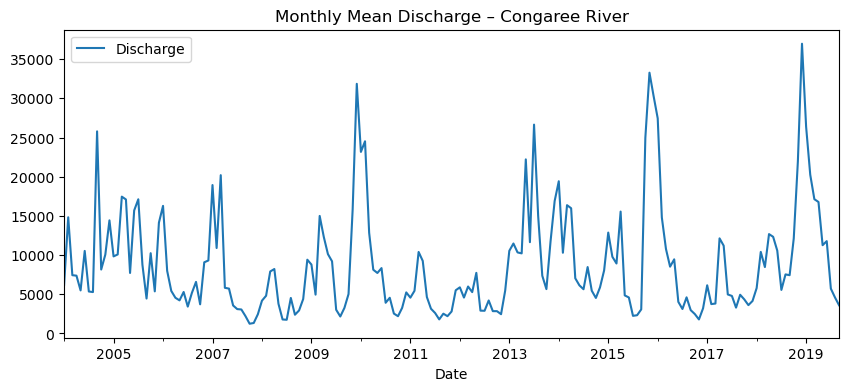

In [44]:
monthly_df = df.resample("M").mean()
monthly_df.plot(title="Monthly Mean Discharge – Congaree River", figsize=(10, 4))


<Axes: title={'center': 'First Difference'}, xlabel='Date'>

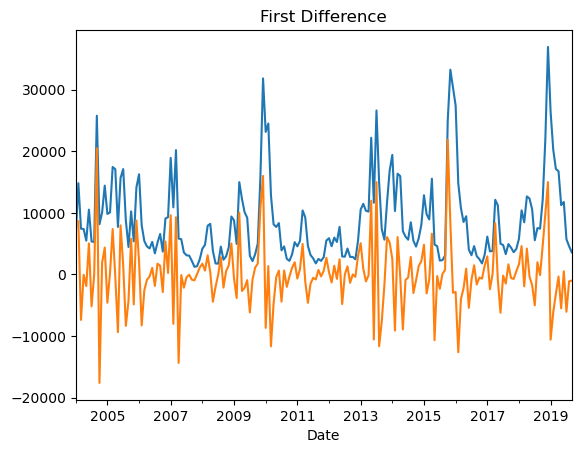

In [45]:
monthly_df["Discharge"].plot(title="Raw Series")
monthly_df["Discharge_diff"] = monthly_df["Discharge"].diff()
monthly_df["Discharge_diff"].plot(title="First Difference")


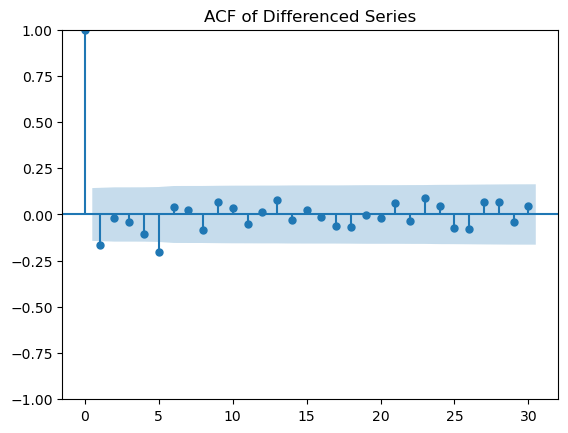

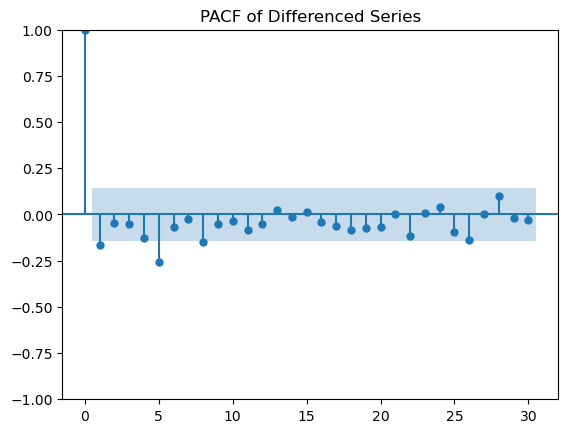

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(monthly_df["Discharge_diff"].dropna(), lags=30)
plt.title("ACF of Differenced Series")
plt.show()

plot_pacf(monthly_df["Discharge_diff"].dropna(), lags=30)
plt.title("PACF of Differenced Series")
plt.show()


In [47]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_df["Discharge"], order=(1, 1, 1))
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:              Discharge   No. Observations:                  189
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1871.909
Date:                Wed, 30 Jul 2025   AIC                           3749.819
Time:                        22:29:02   BIC                           3759.528
Sample:                    01-31-2004   HQIC                          3753.753
                         - 09-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6783      0.045     15.097      0.000       0.590       0.766
ma.L1         -1.0000      0.061    -16.423      0.000      -1.119      -0.881
sigma2      2.559e+07   2.38e-09   1.07e+16      0.0

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

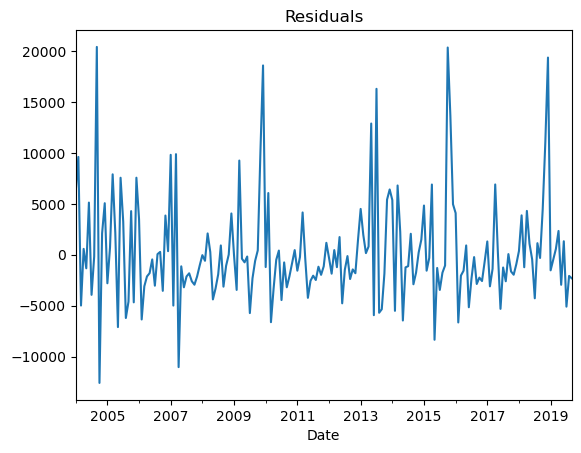

In [48]:
residuals = result.resid
residuals.plot(title="Residuals")


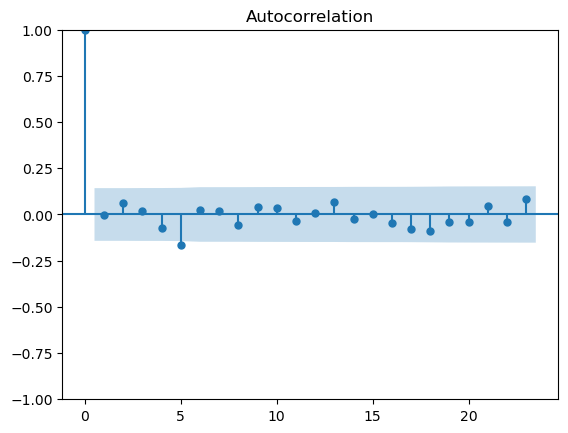

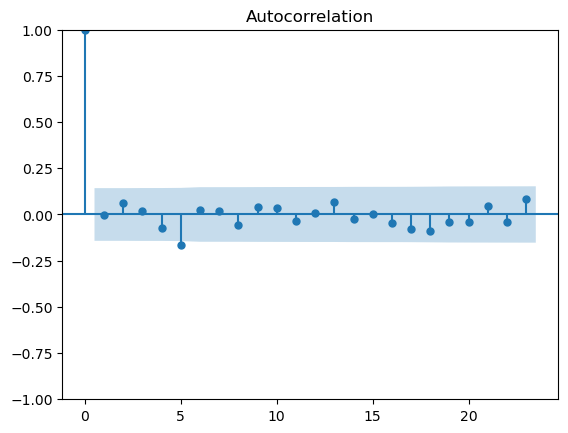

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)


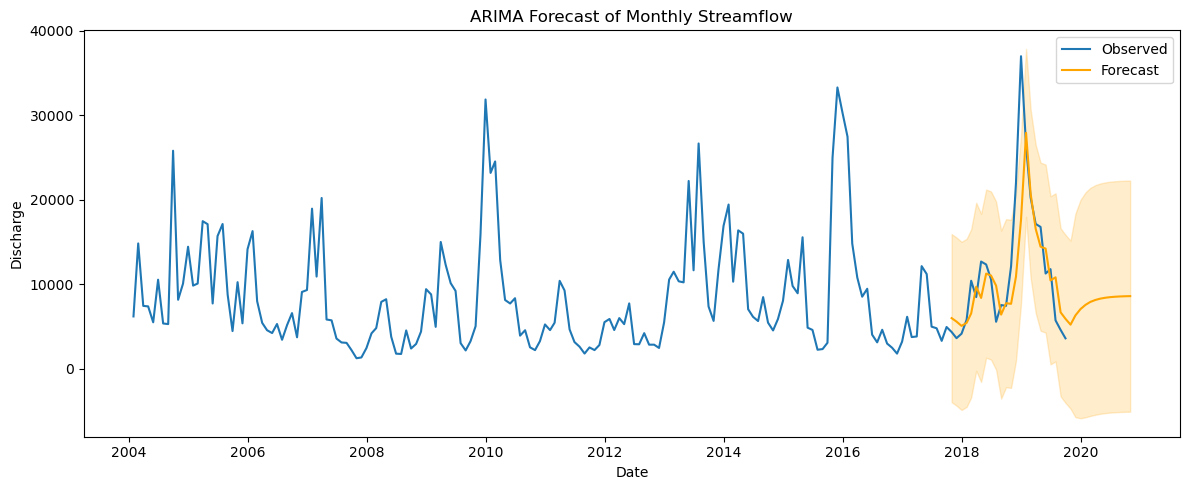

In [51]:
import matplotlib.pyplot as plt

# Forecast: past 24 months + next 12 months
start = len(monthly_df) - 24
end = len(monthly_df) + 12

# Generate predictions
forecast = result.get_prediction(start=start, end=end)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(monthly_df.index, monthly_df['Discharge'], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('ARIMA Forecast of Monthly Streamflow')
plt.legend()
plt.tight_layout()
plt.show()
